##EE 399
##Sam Tam
##5/12/23
##HW 5


In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import integrate
import matplotlib.pyplot as plt

# **Part 1**

In [12]:
# Define a function to generate training data for a given rho value
def generate_training_data(rho):
    # Define the Lorenz system for the given rho value
    def lorenz_deriv(x_y_z, t0, sigma=10, beta=8/3):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    # Set the time step and the total time
    dt = 0.01
    T = 8
    t = np.arange(0, T+dt, dt)

    # Set the number of initial conditions
    n = 100

    # Generate the initial conditions
    np.random.seed(123)
    x0 = -15 + 30 * np.random.random((n, 3))

    # Generate the training data
    nn_input = np.zeros((n*(len(t)-1), 3))
    nn_output = np.zeros_like(nn_input)
    for i in range(n):
        x_t = integrate.odeint(lorenz_deriv, x0[i], t)
        nn_input[i*(len(t)-1):(i+1)*(len(t)-1)] = x_t[:-1]
        nn_output[i*(len(t)-1):(i+1)*(len(t)-1)] = x_t[1:]

    # Convert the training data to PyTorch tensors
    nn_input = torch.from_numpy(nn_input).float()
    nn_output = torch.from_numpy(nn_output).float()

    return nn_input, nn_output

# Define the neural network
class LorenzNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the neural network and define the loss function and optimizer
model = LorenzNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Train the neural network for each value of rho
for rho in [10, 28, 40]:
    nn_input, nn_output = generate_training_data(rho)
    for epoch in range(30):
        optimizer.zero_grad()
        outputs = model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()
        optimizer.step()
        print(f"rho={rho}, epoch={epoch+1}, loss={loss.item():.4f}")

rho=10, epoch=1, loss=46.8785
rho=10, epoch=2, loss=42.0744
rho=10, epoch=3, loss=37.7125
rho=10, epoch=4, loss=33.6928
rho=10, epoch=5, loss=29.9688
rho=10, epoch=6, loss=26.5073
rho=10, epoch=7, loss=23.2546
rho=10, epoch=8, loss=20.2360
rho=10, epoch=9, loss=17.4270
rho=10, epoch=10, loss=14.8273
rho=10, epoch=11, loss=12.4150
rho=10, epoch=12, loss=10.1789
rho=10, epoch=13, loss=8.1337
rho=10, epoch=14, loss=6.3184
rho=10, epoch=15, loss=4.7630
rho=10, epoch=16, loss=3.4903
rho=10, epoch=17, loss=2.5022
rho=10, epoch=18, loss=1.7853
rho=10, epoch=19, loss=1.3190
rho=10, epoch=20, loss=1.0715
rho=10, epoch=21, loss=0.9978
rho=10, epoch=22, loss=1.0398
rho=10, epoch=23, loss=1.1384
rho=10, epoch=24, loss=1.2474
rho=10, epoch=25, loss=1.3306
rho=10, epoch=26, loss=1.3723
rho=10, epoch=27, loss=1.3609
rho=10, epoch=28, loss=1.2941
rho=10, epoch=29, loss=1.1807
rho=10, epoch=30, loss=1.0299
rho=28, epoch=1, loss=7.5060
rho=28, epoch=2, loss=5.3482
rho=28, epoch=3, loss=3.6555
rho=28, ep

In [13]:
# Generate test data for rho=17 and rho=35
nn_input_17, nn_output_17 = generate_training_data(17)
nn_input_35, nn_output_35 = generate_training_data(35)

# Use the trained model to make predictions for rho=17
with torch.no_grad():
    pred_output_17 = model(nn_input_17)

# Use the trained model to make predictions for rho=35
with torch.no_grad():
    pred_output_35 = model(nn_input_35)

# Calculate the test loss for rho=17 and rho=35
test_loss_17 = criterion(pred_output_17, nn_output_17).item()
test_loss_35 = criterion(pred_output_35, nn_output_35).item()

print(f"Test loss for rho=17: {test_loss_17:.4f}")
print(f"Test loss for rho=35: {test_loss_35:.4f}")


Test loss for rho=17: 0.2012
Test loss for rho=35: 0.2385


Text(0.5, 0.98, 'Future state prediction for rho=17')

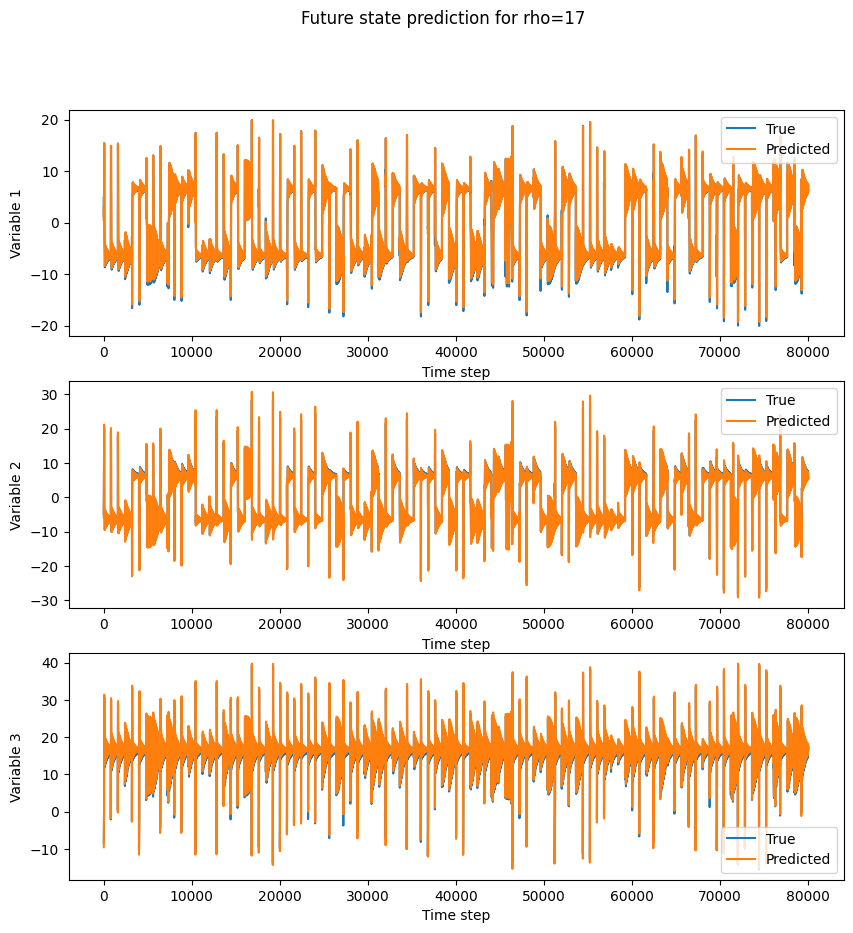

In [14]:
# Plot the true and predicted future states for rho=17
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i in range(3):
    axs[i].plot(nn_output_17[:, i], label='True')
    axs[i].plot(pred_output_17[:, i], label='Predicted')
    axs[i].set_xlabel('Time step')
    axs[i].set_ylabel(f'Variable {i+1}')
    axs[i].legend()
plt.suptitle('Future state prediction for rho=17')

Text(0.5, 0.98, 'Future state prediction for rho=35')

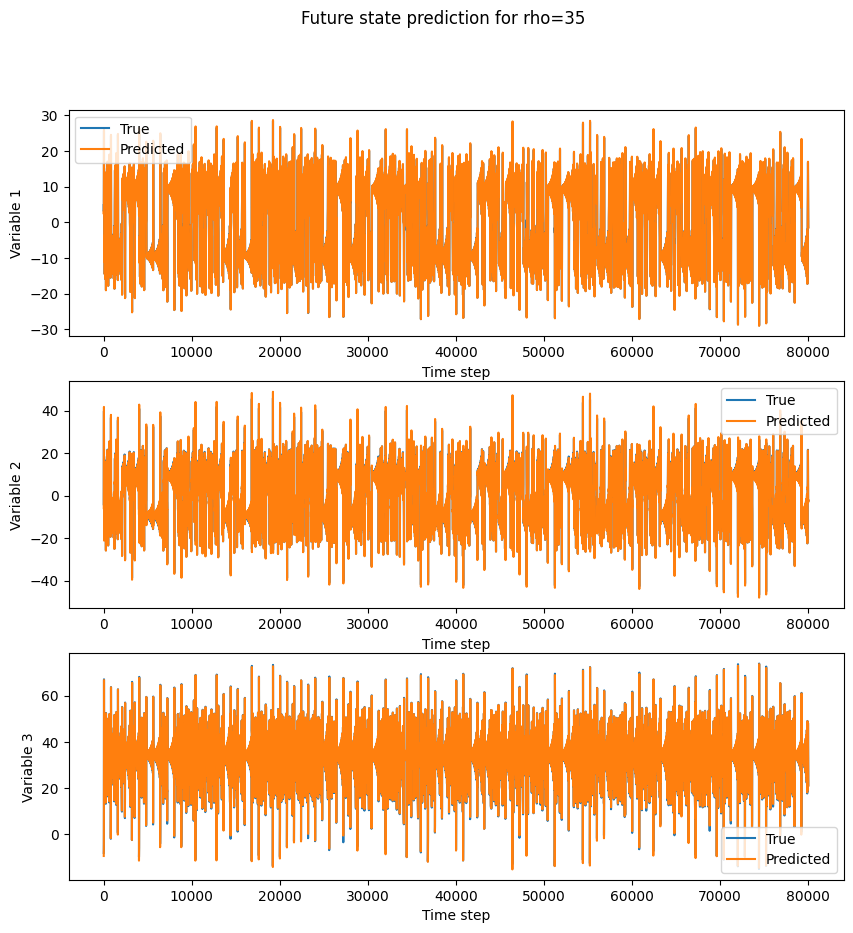

In [15]:
# Plot the true and predicted future states for rho=35
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i in range(3):
    axs[i].plot(nn_output_35[:, i], label='True')
    axs[i].plot(pred_output_35[:, i], label='Predicted')
    axs[i].set_xlabel('Time step')
    axs[i].set_ylabel(f'Variable {i+1}')
    axs[i].legend()
plt.suptitle('Future state prediction for rho=35')

# **Part 2**

In [16]:
class LorenzFFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# Create the LorenzFFNN models
ffnn_model = LorenzFFNN()
criterion = nn.MSELoss()
# Define the optimizers for each model
ffnn_optimizer = optim.Adam(ffnn_model.parameters())
# Train the FFNN for each value of rho
for rho in [10, 28, 40]:
    nn_input, nn_output = generate_training_data(rho)
    for epoch in range(30):
        ffnn_optimizer.zero_grad()
        outputs = ffnn_model(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()
        ffnn_optimizer.step()
# Use the trained FFNN model to make predictions for rho=17
with torch.no_grad():
    pred_output_17_ffnn = ffnn_model(nn_input_17).numpy()

# Use the trained FFNN model to make predictions for rho=35
with torch.no_grad():
    pred_output_35_ffnn = ffnn_model(nn_input_35).numpy()

# Calculate the test loss for rho=17 and rho=35 for FFNN
test_loss_17_ffnn = np.mean((pred_output_17_ffnn - nn_output_17.numpy()) ** 2)
test_loss_35_ffnn = np.mean((pred_output_35_ffnn - nn_output_35.numpy()) ** 2)

print(f"FFNN test loss for rho=17: {test_loss_17_ffnn:.4f}")
print(f"FFNN test loss for rho=35: {test_loss_35_ffnn:.4f}")

FFNN test loss for rho=17: 0.3170
FFNN test loss for rho=35: 0.2311


In [41]:
class LorenzLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(3, 50, batch_first=True)
        self.fc1 = nn.Linear(50, 3)
        
    def forward(self, x):
        _, h_n = self.lstm1(x)
        x = self.fc1(h_n[-1])
        return x
# Create the LSTM and define the loss function and optimizer
lstm = LorenzLSTM()
criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm.parameters())
# Train the LSTM for each value of rho
for rho in [10, 28, 40]:
    nn_input, nn_output = generate_training_data(rho)
    for epoch in range(30):
        lstm_optimizer.zero_grad()
        outputs = lstm(nn_input)
        loss = criterion(outputs, nn_output)
        loss.backward()
        lstm_optimizer.step()
with torch.no_grad():
    pred_output_17_lstm = lstm(nn_input_17).numpy()

# Use the trained LSTM model to make predictions for rho=35
with torch.no_grad():
    pred_output_35_lstm = lstm(nn_input_35).numpy()

# Calculate the test loss for rho=17 and rho=35 for LSTM
test_loss_17_lstm = np.mean((pred_output_17_lstm - nn_output_17.numpy()) ** 2)
test_loss_35_lstm = np.mean((pred_output_35_lstm - nn_output_35.numpy()) ** 2)

print(f"LSTM test loss for rho=17: {test_loss_17_lstm:.4f}")
print(f"LSTM test loss for rho=35: {test_loss_35_lstm:.4f}")

LSTM test loss for rho=17: 107.9591
LSTM test loss for rho=35: 323.1058


In [42]:
class LorenzRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(3, 50, batch_first=True)
        self.fc = nn.Linear(50, 3)
        
    def forward(self, x):
        _, h_n = self.rnn(x)
        x = self.fc(h_n[-1])
        return x
# Create the LorenzRNN model
rnn_model = LorenzRNN()
criterion = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters())
# Train the RNN for each value of rho
for rho in [10, 28, 40]:
    nn_input, nn_output = generate_training_data(rho)
    for epoch in range(30):
        rnn_optimizer.zero_grad()
        outputs = rnn_model(nn_input.unsqueeze(0))
        loss = criterion(outputs, nn_output)
        loss.backward()
        rnn_optimizer.step()
# Use the trained RNN model to make predictions for rho=17
with torch.no_grad():
    pred_output_17_rnn = rnn_model(nn_input_17).numpy()

# Use the trained RNN model to make predictions for rho=35
with torch.no_grad():
    pred_output_35_rnn = rnn_model(nn_input_35).numpy()

# Calculate the test loss for rho=17 and rho=35 for RNN
test_loss_17_rnn = np.mean((pred_output_17_rnn - nn_output_17.numpy()) ** 2)
test_loss_35_rnn = np.mean((pred_output_35_rnn - nn_output_35.numpy()) ** 2)

print(f"RNN test loss for rho=17: {test_loss_17_rnn:.4f}")
print(f"RNN test loss for rho=35: {test_loss_35_rnn:.4f}")

RNN test loss for rho=17: 61.8937
RNN test loss for rho=35: 283.8249


In [55]:
class LorenzRNN:
    def __init__(self, n_reservoir=100, spectral_radius=0.9, noise=0.01):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.noise = noise

    def fit(self, input_data, output_data):
        np.random.seed(42)
        self.W_in = np.random.rand(self.n_reservoir, input_data.shape[1]) - 0.5
        self.W = np.random.rand(self.n_reservoir, self.n_reservoir) - 0.5
        self.W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(self.W)))
        self.X = np.zeros((input_data.shape[0], self.n_reservoir))
        for t in range(1, input_data.shape[0]):
            self.X[t] = np.tanh(np.dot(input_data[t], self.W_in.T) + np.dot(self.X[t - 1], self.W))
        self.W_out = np.dot(np.linalg.pinv(self.X), output_data)

    def predict(self, input_data):
        predictions = np.zeros((input_data.shape[0], self.W_out.shape[1]))
        x = np.copy(self.X[-1])
        for t in range(input_data.shape[0]):
            x = np.tanh(np.dot(input_data[t], self.W_in.T) + np.dot(x, self.W))
            predictions[t] = np.dot(x, self.W_out)
        return predictions

class MyESNModel:
    def __init__(self, n_reservoir=100, spectral_radius=0.9, noise=0.01):
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.noise = noise

    def train(self, rho):
        nn_input, nn_output = generate_training_data(rho)
        esn = LorenzRNN(n_reservoir=self.n_reservoir, spectral_radius=self.spectral_radius, noise=self.noise)
        esn.fit(nn_input, nn_output)
        return esn

esn_model = MyESNModel()

for rho in [17, 35]:
    nn_input, nn_output = generate_training_data(rho)
    esn = esn_model.train(rho)
    predicted_output = torch.tensor(esn.predict(nn_input))
    loss = torch.mean((predicted_output - nn_output) ** 2)
    print(f"ESN test loss for rho={rho}: {loss:.4f}")


ESN test loss for rho=17: 0.2574
ESN test loss for rho=35: 2.5307
